# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import re
from keras.callbacks import ModelCheckpoint, LambdaCallback

2025-03-28 13:14:33.458594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-28 13:14:33.544352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-28 13:14:33.596300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 13:14:34.286817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import platform
print(platform.system())

Linux


In [3]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1) DATA PRE-PROCESSING

a) Load in kaggle data labels + image file paths

b) combine kaggle data labels and image file paths into one dataframe

c) load in the extra 486 image file paths

d) extract the speed and angle labels from the file path names

e) store that extra data in a pandas df and do the value normalisation

f) merge the kaggle and extra data dfs

g) EDA

h) convert the images to numerical RGB feature maps

i) split data into training-validation sets

j) data augmentation applied to training set

### 1a) load in kaggle data labels + image file paths

In [5]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
# labels_file_path = '/home/ppytr13/machine-learning-in-science-ii-2025/training_norm.csv' # tyler hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [6]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # OG data ben hpc file path (mlis2 cluster)
# image_folder_path = '/home/ppytr13/machine-learning-in-science-ii-2025//training_data/training_data'
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [7]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [8]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


### 1b) Combine the kaggle labels and image file paths into one dataframe

In [9]:
kaggle_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
kaggle_df['speed'] = kaggle_df['speed'].round(6) # to get rid of floating point errors

In [10]:
kaggle_df.tail()

,angle,speed,image_file_paths
image_id,,,
13794,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13794.png
13795,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13795.png
13796,0.5625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13796.png
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13798.png


In [11]:
kaggle_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3143.png


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) load in the extra 486 labels image file paths

In [12]:
extradata_folder_path = '/home/apyba3/petru_data'

extradata_file_paths = [
    os.path.join(extradata_folder_path, f)
    for f in os.listdir(extradata_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

### 1d) extract the speed and angle labels from the file path names

image file path name follows the pattern: `randomnumber_angle_speed`

In [13]:
# Regex pattern to extract angle and speed values
pattern = r'(\d+)_([\d]+)_([\d]+)\.png'

angle_value = []
speed_value = []

# Loop through file paths and extract angle and speed values
for file_path in extradata_file_paths:
    match = re.search(pattern, file_path)
    if match:
        # Extract random number, angle, and speed values
        random_number = match.group(1)
        angle_value.append(int(match.group(2)))
        speed_value.append(int(match.group(3)))

checking it has stored the labels correctly (check if the angle_value order matches that of the file path)

In [14]:
print(angle_value[:3])
print(extradata_file_paths[:3])

[95, 100, 80]
['/home/apyba3/petru_data/1712918428740_95_0.png', '/home/apyba3/petru_data/1712923220525_100_50.png', '/home/apyba3/petru_data/1712923068961_80_35.png']


### 1e) store that extra data in a pandas df and do the value normalisation

In [15]:
extradata_df = pd.DataFrame({
    'angle': angle_value,
    'speed': speed_value,
    'image_file_paths': extradata_file_paths
})

# conversions (see kaggle data section)
extradata_df.loc[extradata_df['speed'] > 0, 'speed'] = 1
extradata_df['speed'] = pd.to_numeric(extradata_df['speed'], errors='coerce').fillna(0).astype(int)

extradata_df['angle'] = (extradata_df['angle'] - 50)/80

extradata_df.index = pd.RangeIndex(start=13799, stop=13799 + len(extradata_df), step=1)
extradata_df.index.name = 'image_id'

extradata_df.head()

,angle,speed,image_file_paths
image_id,,,
13799,0.5625,0,/home/apyba3/petru_data/1712918428740_95_0.png
13800,0.6250,1,/home/apyba3/petru_data/1712923220525_100_50.png
13801,0.3750,1,/home/apyba3/petru_data/1712923068961_80_35.png
13802,0.6875,0,/home/apyba3/petru_data/1712921566265_105_0.png
13803,0.2500,1,/home/apyba3/petru_data/1712915924250_70_35.png


### 1f) merge the kaggle and extra data dfs

In [16]:
merged_df = pd.concat([kaggle_df, extradata_df])
merged_df.loc[13797:13800]

,angle,speed,image_file_paths
image_id,,,
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13798.png
13799,0.5625,0.0,/home/apyba3/petru_data/1712918428740_95_0.png
13800,0.6250,1.0,/home/apyba3/petru_data/1712923220525_100_50.png


### 1g) EDA - angle column

In [17]:
merged_df.value_counts('angle')

angle
0.5000    2172
0.7500    2172
0.6875    2049
0.6250    2000
0.5625    1644
0.4375    1520
0.8125    1162
0.3750     447
0.8750     308
0.3125     229
0.1875     119
0.2500     118
0.1250     114
0.0000      75
0.9375      74
0.0625      38
1.0000      38
Name: count, dtype: int64

note: imbalance datset

we want to remove the row containing the erroneous 1.428571 speed value

In [18]:
cleaned_df = merged_df[merged_df['angle'] != 1.428571]

### 1h) convert images to numerical RGB feature maps

In [19]:
BATCH_SIZE = 32

In [20]:
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalise pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["angle"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

2025-03-28 13:15:01.541763: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


lets check and see if what we have done works

In [21]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

2025-03-28 13:15:12.152346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 2726 of 14279
2025-03-28 13:15:32.136063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 9891 of 14279


(32, 224, 224, 3) (32,)


2025-03-28 13:15:45.336259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-28 13:15:45.354225: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 1i) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [22]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [23]:
print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

Train size: 357, validation size: 90


### 1j) Data Augmentation applied to training set

- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment



In [ ]:
def augment_image(image, label):
  seed = (6, 9)
  image = tf.image.stateless_random_brightness(image, 0.2, seed)
  image = tf.image.stateless_random_contrast(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_hue(image, 0.2, seed)
  image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed)
  return image, label

# Create a dataset of augmented images from the original train_dataset
augmented_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Concatenate the original and augmented datasets
train_dataset = train_dataset.concatenate(augmented_dataset)

# Shuffle the combined dataset
train_dataset = train_dataset.shuffle(buffer_size=len(cleaned_df))

count how many images are in the training set - 22016 with no extradata and 80-20 split

In [25]:
total_images = 0
for image_batch, _ in train_dataset:
    total_images += image_batch.shape[0]  # Add the batch size

print(f"Total number of images in train_dataset: {total_images}")

2025-03-28 13:15:51.762481: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total number of images in train_dataset: 22848


checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 0.5
image shape:  (224, 224, 3)
label: 0.5625
image shape:  (224, 224, 3)
label: 0.4375
image shape:  (224, 224, 3)
label: 0.5625
image shape:  (224, 224, 3)
label: 0.75
image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.8125
image shape:  (224, 224, 3)
label: 0.1875


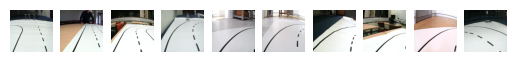

In [26]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in train_dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

# 2) Model Building -  Transfer Learning

### 2a) Set up model architecture

In [27]:
dropoutrate = 0.2
input_shape = (224,224,3)

In [28]:
mobnetv3small = tf.keras.applications.MobileNetV3Small(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

model = tf.keras.Sequential([
  mobnetv3small,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

mobnetv3small.trainable = False  # freeze mobnetv3small layers

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130,097 (4.31 MB)

 Trainable params: 190,977 (746.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

compile the model

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
)

### 2c) train the model with the mobnetv3small layers frozen

In [30]:
# Define ModelCheckpoint callback
checkpoint_filepath = '/home/apyba3/MobNetV3Small/mobnetv3smallcheckpoint.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Define a callback to print epoch tracking info
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

# Training loop with added callback
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint, epoch_callback]  # Include both callbacks
)



Starting Epoch 1...
Epoch 1/50
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0583 
Epoch 1: val_loss improved from inf to 0.03172, saving model to /home/apyba3/MobNetV3Small/mobnetv3smallcheckpoint.keras
Completed Epoch 1, Loss: 0.0335, Val Loss: 0.0317
714/714 ━━━━━━━━━━━━━━━━━━━━ 74s 90ms/step - loss: 0.0583 - val_loss: 0.0317

Starting Epoch 2...
Epoch 2/50
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0200 
Epoch 2: val_loss improved from 0.03172 to 0.02856, saving model to /home/apyba3/MobNetV3Small/mobnetv3smallcheckpoint.keras
Completed Epoch 2, Loss: 0.0199, Val Loss: 0.0286
714/714 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - loss: 0.0200 - val_loss: 0.0286

Starting Epoch 3...
Epoch 3/50
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0189 
Epoch 3: val_loss improved from 0.02856 to 0.02240, saving model to /home/apyba3/MobNetV3Small/mobnetv3smallcheckpoint.keras
Completed Epoch 3, Loss: 0.0185, Val Loss: 0.0224
714/714 ━━━━━━━━━━━━━━━━━━━━ 70s 88ms/step - loss: 0.01

save model weights

In [31]:
model.save_weights('/home/apyba3/car_frozen_regression_mobnetv3small.weights.h5')
# model.save_weights('/home/ppytr13/car_frozen.weights.h5')

clear keras session

In [32]:
tf.keras.backend.clear_session() #Clear keras session

### 2d) fine-tuning

rebuild model after clearing keras session

In [28]:
mobnetv3small = tf.keras.applications.MobileNetV3Small(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

model = tf.keras.Sequential([
  mobnetv3small,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

mobnetv3small.trainable = True  # Make the entire model trainable

model.summary() # print the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130,097 (4.31 MB)

 Trainable params: 1,117,985 (4.26 MB)

 Non-trainable params: 12,112 (47.31 KB)

compile the model

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # deliberately smaller learning rate
    loss=tf.keras.losses.MeanSquaredError(),
)

now load in the learned weights from training

In [30]:
model.load_weights('/home/apyba3/car_frozen_regression_mobnetv3small.weights.h5')
# model.load_weights('/home/ppytr13/car_frozen.weights.h5')

/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Initiate fine-tuning training

In [31]:
# Define ModelCheckpoint callback
checkpoint_filepath = '/home/apyba3/MobNetV3Small/mobnetv3smallcheckpoint.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Define a callback to print epoch tracking info
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

# Training loop with added callback
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=38,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint, epoch_callback]  # Include both callbacks
)



Starting Epoch 1...
Epoch 1/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 1.7482   
Epoch 1: val_loss improved from inf to 0.02090, saving model to /home/apyba3/MobNetV3Small/mobnetv3smallcheckpoint.keras
Completed Epoch 1, Loss: 0.3715, Val Loss: 0.0209
714/714 ━━━━━━━━━━━━━━━━━━━━ 331s 435ms/step - loss: 1.7463 - val_loss: 0.0209

Starting Epoch 2...
Epoch 2/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 0.0235  
Epoch 2: val_loss did not improve from 0.02090
Completed Epoch 2, Loss: 0.0222, Val Loss: 0.0315
714/714 ━━━━━━━━━━━━━━━━━━━━ 315s 432ms/step - loss: 0.0235 - val_loss: 0.0315

Starting Epoch 3...
Epoch 3/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 0.0186  
Epoch 3: val_loss did not improve from 0.02090
Completed Epoch 3, Loss: 0.0177, Val Loss: 0.0344
714/714 ━━━━━━━━━━━━━━━━━━━━ 315s 432ms/step - loss: 0.0186 - val_loss: 0.0344

Starting Epoch 4...
Epoch 4/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 0.0158  
Epoch 4: val_loss did not imp

KeyboardInterrupt: 

save the weights learned from fine tuning

In [32]:
model.save_weights('car_unfrozen_regression_mobnetv3small.weights.h5')
# model.save_weights('/home/ppytr13/car_unfrozen.weights.h5')

# 3) Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [33]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
# image_folder_path = '/home/ppyt13/machine-learning-in-science-ii-2025/test_data/test_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/5.png


### 3b) convert test images to numerical RGB feature maps

In [34]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [35]:
predictions = model.predict(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step


### 3d) correctly format the predictions into a pandas dataframe

In [36]:
predictions_df = pd.DataFrame(predictions, columns=['angle'])

In [37]:
predictions_df.head()

,angle
0,0.573428
1,0.732077
2,0.188098
3,0.196967
4,0.169281


In [38]:
predictions_df['angle'].value_counts()

angle
0.254174    1
0.573428    1
0.732077    1
0.188098    1
0.196967    1
0.169281    1
0.660120    1
0.653696    1
0.743585    1
0.631948    1
0.566528    1
0.581694    1
0.715047    1
0.448052    1
0.543990    1
0.228387    1
0.558458    1
0.557174    1
0.724658    1
0.452504    1
0.128574    1
0.850488    1
0.225213    1
0.224168    1
0.731123    1
0.689312    1
0.674881    1
0.631100    1
0.203592    1
0.608497    1
0.671797    1
0.671608    1
0.662162    1
0.190784    1
0.438939    1
0.697620    1
0.564853    1
0.514004    1
0.656687    1
0.581329    1
0.440722    1
0.705727    1
0.691638    1
0.739633    1
0.653484    1
0.515683    1
0.577943    1
0.541233    1
0.654818    1
0.256934    1
0.746365    1
0.581792    1
0.663440    1
0.165161    1
0.117512    1
0.152427    1
0.525718    1
0.215527    1
0.531891    1
0.419353    1
0.447581    1
0.497297    1
0.508197    1
0.181916    1
0.627600    1
0.222633    1
0.526223    1
0.459289    1
0.817422    1
0.399599    1
0.542744    1


### 3e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

In [39]:
predictions_df.to_csv('/home/apyba3/mobnetv3small_angleregression_withvalidation_withpetrudata.csv')